In [182]:
import math
import random
import string

random.seed(0)

In [183]:
# calculate a random number where:  a <= rand < b
def rand(a, b):
    return (b-a)*random.random() + a

# Make a matrix (we could use NumPy to speed this up)
def makeMatrix(I, J, fill=0.0):
    m = []
    for i in range(I):
        m.append([fill]*J)
    return m

# our sigmoid function, tanh is a little nicer than the standard 1/(1+e^-x)
def sigmoid(x):
    return math.tanh(x)
#     return 1/(1+math.pow(math.e,-x))

# derivative of our sigmoid function, in terms of the output (i.e. y)
def dsigmoid(y):
    return 1.0 - y**2
#     return y*(1-y)

In [184]:
class NN:
    def __init__(self, ni, nh, no):
        # number of input, hidden, and output nodes
        self.ni = ni + 1 # +1 for bias node
        self.nh = nh
        self.no = no

        # activations for nodes
        self.ai = [1.0]*self.ni
        self.ah = [1.0]*self.nh
        self.ao = [1.0]*self.no
        
        # create weights
#         self.wi = [[0.15,0.25],[0.2,0.3],[0.5,0.5]]
#         self.wo = [[0.4], [0.5]]
        self.wi = makeMatrix(self.ni, self.nh)
        self.wo = makeMatrix(self.nh, self.no)
        # set them to random vaules
        for i in range(self.ni):
            for j in range(self.nh):
                self.wi[i][j] = rand(-0.2, 0.2)
        for j in range(self.nh):
            for k in range(self.no):
                self.wo[j][k] = rand(-2.0, 2.0)
        
        # last change in weights for momentum   
        self.ci = makeMatrix(self.ni, self.nh)
        self.co = makeMatrix(self.nh, self.no)
    
    ## 計算網路的輸出的函數
    def update(self, inputs):
        if len(inputs) != self.ni-1:
            raise ValueError('wrong number of inputs')

        # input activations
        for i in range(self.ni-1):
            self.ai[i] = inputs[i]

        # hidden activations 計算隱藏層輸出值
        for j in range(self.nh):
            sum = 0.0
            for i in range(self.ni):
                sum = sum + self.ai[i] * self.wi[i][j]
            self.ah[j] = sigmoid(sum)
#             print('H',j+1,': ',self.ah[j])

        # output activations 計算輸出層輸出值 
        for k in range(self.no):
            sum = 0.0
            for j in range(self.nh):
                sum = sum + self.ah[j] * self.wo[j][k]
            self.ao[k] = sigmoid(sum)
#             print('y',j+1,': ',self.ao[k])

        return self.ao[:]
    
    ## backPropagate()：反傳遞學習的函數
    def backPropagate(self, targets, N, M):
        if len(targets) != self.no:
            raise ValueError('wrong number of target values')

        # calculate error terms for output
        output_deltas = [0.0] * self.no
        for k in range(self.no):
#             error = targets[k]-self.ao[k]
            error=(targets[k]-self.ao[k])
            output_deltas[k] = dsigmoid(self.ao[k]) * error

        # calculate error terms for hidden
        hidden_deltas = [0.0] * self.nh
        for j in range(self.nh):
            error = 0.0
            for k in range(self.no):
                error = error + output_deltas[k]*self.wo[j][k]
            hidden_deltas[j] = dsigmoid(self.ah[j]) * error

        # update output weights
        for j in range(self.nh):
            for k in range(self.no):
                change = output_deltas[k]*self.ah[j]
                self.wo[j][k] = self.wo[j][k] + N*change + M*self.co[j][k]
                self.co[j][k] = change

        # update input weights
        for i in range(self.ni):
            for j in range(self.nh):
                change = hidden_deltas[j]*self.ai[i]
                self.wi[i][j] = self.wi[i][j] + N*change + M*self.ci[i][j]
                self.ci[i][j] = change

        # calculate error
        error = 0.0
#         for k in range(len(targets)):
#             error = error + 0.5*(targets[k]-self.ao[k])**2
#         return error
        for k in range(len(targets)):
            error = error + (targets[k]-self.ao[k])**2
        return error/self.no
    
    def test(self, patterns):
        pred=[]
        for p in patterns:
            print(p[0], '-> predict:', self.update(p[0]),' true:',p[1])
            pred.append(self.update(p[0])[0])
        return pred

    def weights(self):
        print('Input weights:')
        for i in range(self.ni):
            print(self.wi[i])
        print()
        print('Output weights:')
        for j in range(self.nh):
            print(self.wo[j])

    def train(self, patterns, iterations=1000, N=0.5, M=0.1):
        # N: learning rate
        # M: momentum factor
        for i in range(iterations):
            error = 0.0
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.update(inputs)
                error = error + self.backPropagate(targets, N, M)
            if i % 100 == 0:
                print('error %-.5f' % error)

In [185]:
import numpy as np
# generate random data-set
np.random.seed(0)
noise = np.random.rand(100, 1)
rng = np.random.RandomState(1)
X = rng.rand(100, 2)
Y = 0.5 + np.dot(X, [1.5, -1.])
learnData=[]
for i in range(100):
    learnData.append([X[i],[Y[i]]])

In [186]:
# Tranning data
data = [[[2,-1],[0.01]]]

# create a network with two input, two hidden, and one output nodes
n = NN(2, 3, 1)
n.weights()
# train it with some patterns
n.train(learnData,10000,0.6)
n.weights()
# test it
pred=n.test(learnData)

Input weights:
[0.13776874061001926, 0.10318176117612099, -0.031771367667662004]
[-0.09643329988281467, 0.004509888547443414, -0.03802634501983429]
[0.11351943561390904, -0.07867490956842903, -0.009361218339057675]

Output weights:
[0.3335281578201248]
[1.6324515407813407]
[0.018747423269561025]
error 13.48742
error 3.51157
error 3.51579
error 3.49516
error 3.47081
error 3.45425
error 3.44531
error 3.44068
error 3.43824
error 3.43684
error 3.43591
error 3.43517
error 3.43451
error 3.43387
error 3.43324
error 3.43262
error 3.43202
error 3.43144
error 3.43090
error 3.43039
error 3.42993
error 3.42951
error 3.42913
error 3.42878
error 3.42847
error 3.42819
error 3.42794
error 3.42771
error 3.42750
error 3.42731
error 3.42713
error 3.42697
error 3.42682
error 3.42669
error 3.42657
error 3.42645
error 3.42635
error 3.42626
error 3.42617
error 3.42609
error 3.42602
error 3.42595
error 3.42589
error 3.42583
error 3.42578
error 3.42574
error 3.42569
error 3.42565
error 3.42561
error 3.42558
er

In [174]:
# 學習後的權重
n.weights()

Input weights:
[0.7752611519361811, 4.83466508958236, 1.7725950889873079]
[0.30624297837870496, -3.2365057836282607, -1.2821500512928392]
[2.316651825323105, -2.444098864565266, 0.4517646935549131]

Output weights:
[4.5206576807136525]
[4.297282458593665]
[0.8289972595795668]


In [175]:
sigmoid(0.64566*0.4+0.66819*0.5)

0.531590104135168

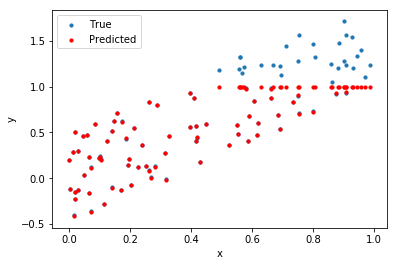

In [187]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], Y, s=10, label='True')
plt.scatter(X[:,0], pred, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [188]:
for i in range(100):
    print(pred[i],Y[i])

0.4067780526907143 0.40520851361170285
0.19514664624715128 0.19783898959417756
0.6258781121680521 0.6277952414568717
0.4366660145868872 0.4338295900234586
0.5564230365760745 0.556334477342648
0.4454206545695186 0.44357227120818277
-0.07350188134698929 -0.07143906179366932
-0.1321526110488855 -0.12938612038151298
0.5668885476341313 0.5672673751049387
0.5149265170246144 0.5124789188079719
0.7280783582524261 0.7328552772939074
0.27682069268393505 0.2778136515695502
0.9278111215908333 0.91997706494021
0.5885889933281986 0.5885115338217846
-0.12491392345709867 -0.12339687408255973
0.224395463341069 0.22641262574452298
0.9999999755983042 1.4036690102527358
0.9999938144349155 1.222300039919647
0.6899843907935512 0.6951257196250026
-0.22553835757622756 -0.22271189892867982
0.9999966810518478 1.2351259789799027
0.12768806820154702 0.13138665964511925
0.2044147032307634 0.20694548369055787
0.9999999949636958 1.569279106265964
0.8001044662412385 0.8016344357612455
-0.15249011301313947 -0.14978509